In [1]:
import tensorflow as tf
import os
import sys
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from itertools import chain
from skimage.io import imread, imshow
import random
from keras.optimizers import SGD, Adam

tf.enable_eager_execution()
 
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
 
DATA_PATH = 'corrosion/Training/'
 
 
seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[1]
 
X = np.zeros((len(os.listdir(os.path.join(DATA_PATH, "images"))), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(os.listdir(os.path.join(DATA_PATH, "images"))), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#Carrega dataset corretamente
for n, img_name in enumerate(os.listdir(os.path.join(DATA_PATH, "images"))):
    img = imread(os.path.join(DATA_PATH,"images",img_name))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(os.path.join(DATA_PATH,"masks",img_name))
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                              preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y[n] = mask
    
"""
        for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
            path = TRAIN_PATH + id_
            img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True)
            X_train_storage.append(img[None])            
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
                mask = np.maximum(mask, mask_)
            Y_train_storage.append(mask[None])
"""
 
x_train=X
 
y_train=Y

Using TensorFlow backend.


In [2]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)    

In [3]:
#Treino
checkpoint_path = "model/model_checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=40,callbacks=callbacks)

Train on 1790 samples, validate on 448 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
1776/1790 [============================>.] - ETA: 0s - loss: 4.0389 - acc: 0.9111
Epoch 00001: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
1790/1790 [==============================] - 12s 7ms/sample - loss: 4.0363 - acc: 0.9107 - val_loss: 3.6232 - val_acc: 0.8850
Epoch 2/40
1776/1790 [============================>.] - ETA: 0s - loss: 2.5880 - acc: 0.9241
Epoch 00002: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 2.5777 - acc: 0.9243 - val_loss: 2.7204 - val_acc: 0.9220
Epoch 3/40
1776/1790 [============================>.] - ETA: 0s - loss: 2.1352 - acc: 0.9438
Epoch 00003: savin

1790/1790 [==============================] - 9s 5ms/sample - loss: 1.3031 - acc: 0.9689 - val_loss: 1.7962 - val_acc: 0.9581
Epoch 13/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.9995 - acc: 0.9762
Epoch 00013: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 1.0016 - acc: 0.9760 - val_loss: 1.1030 - val_acc: 0.9742
Epoch 14/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.9001 - acc: 0.9789
Epoch 00014: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.9036 - acc: 0.9787 - val_loss: 1.2756 - val_acc: 0.9708
Epoch 15/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.8206 - acc: 0.9803
Epoch 00015: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790

1776/1790 [============================>.] - ETA: 0s - loss: 0.6874 - acc: 0.9832
Epoch 00025: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.6829 - acc: 0.9834 - val_loss: 1.0049 - val_acc: 0.9763
Epoch 26/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.6456 - acc: 0.9841
Epoch 00026: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.6461 - acc: 0.9841 - val_loss: 0.8994 - val_acc: 0.9790
Epoch 27/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.6217 - acc: 0.9845
Epoch 00027: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.6208 - acc: 0.9846 - val_loss: 0.6746 - val_acc: 0.9843
Epoch 28/40
1776

1790/1790 [==============================] - 9s 5ms/sample - loss: 0.5896 - acc: 0.9849 - val_loss: 0.6307 - val_acc: 0.9853
Epoch 38/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.9864
Epoch 00038: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.5345 - acc: 0.9863 - val_loss: 0.6072 - val_acc: 0.9856
Epoch 39/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.5512 - acc: 0.9859
Epoch 00039: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790/1790 [==============================] - 9s 5ms/sample - loss: 0.5497 - acc: 0.9860 - val_loss: 0.5654 - val_acc: 0.9863
Epoch 40/40
1776/1790 [============================>.] - ETA: 0s - loss: 0.5668 - acc: 0.9856
Epoch 00040: saving model to model/model_checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1790

In [4]:
import matplotlib.pyplot as plt
idx = random.randint(0, len(x_train))
print(idx)
#1831 534 <-- good
idx = 1831
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)


print("Image:")
imshow(x_train[idx])
plt.show()

print("Prediction:")
imshow(np.squeeze(predict[0]))
plt.show()

print("Ground truth: ")
imshow(np.squeeze(y_train[idx]))
plt.show()

1904
1/1 [==============================] - 0s 272ms/sample
Image:


<Figure size 640x480 with 1 Axes>

Prediction:


/home/lucca/.virtualenvs/wtf/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


<Figure size 640x480 with 2 Axes>

Ground truth: 


<Figure size 640x480 with 1 Axes>

In [5]:
#Validacao

DATA_PATH = "corrosion/Validation"

x_val = np.zeros((len(os.listdir(os.path.join(DATA_PATH, "images"))), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_val = np.zeros((len(os.listdir(os.path.join(DATA_PATH, "images"))), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, img_name in enumerate(os.listdir(os.path.join(DATA_PATH, "images"))):
    img = imread(os.path.join(DATA_PATH,"images",img_name))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_val[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(os.path.join(DATA_PATH,"masks",img_name))
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                              preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    y_val[n] = mask


In [6]:
results_val = model.evaluate(x_val, y_val, batch_size=6)
print('val loss, val acc:', results_val)

529/529 [==============================] - 1s 2ms/sample - loss: 0.2225 - acc: 0.9850
val loss, val acc: [0.22253353800426548, 0.9850329]


(529, 128, 128, 3)
1/1 [==============================] - 0s 3ms/sample
Image:


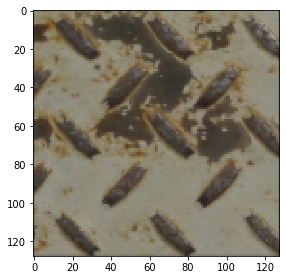

Prediction:


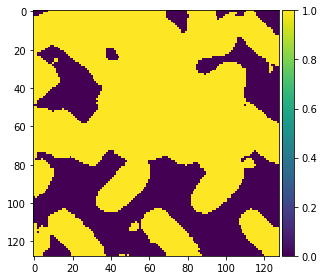

Ground truth: 


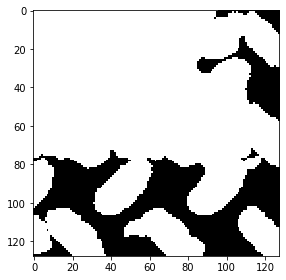

In [7]:
idx = random.randint(0, len(x_val))
print(x_val.shape)
#161 3 339 <-- good
idx=161
x=np.array(x_val[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)

print("Image:")
imshow(x_val[idx])
plt.show()

print("Prediction:")
imshow(np.squeeze(predict[0]))
plt.show()

print("Ground truth: ")
imshow(np.squeeze(y_val[idx]))
plt.show()

In [8]:
def plot_learningcurves(loss_tr, loss_ts, acc_tr, acc_ts):
    '''
    Escrever texto... bla bla bla....

    :param  loss_tr:        Train Loss.
    :param  loss_ts:        Test Loss.
    :param  acc_tr:         Accuracy train.
    :param  acc_ts:         Accuracy test.
    :return:                Plot learning curves.
    '''
    # Visualize Model Training History in Keras.
    plt.close('all')
    fig, ax = plt.subplots(ncols = 2, figsize = (8, 4), sharex = True, sharey = True)
    # Summarize history for accuracy.
    ax[0].plot(acc_tr)
    ax[0].plot(acc_ts)
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].grid(True)
    ax[0].legend(['train', 'test'], loc = 'lower right')
    # Summarize history for loss.
    ax[1].plot(loss_tr)
    ax[1].plot(loss_ts)
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].grid(True)
    ax[1].legend(['train', 'test'], loc = 'upper right')
    fig.tight_layout()
    plt.show()

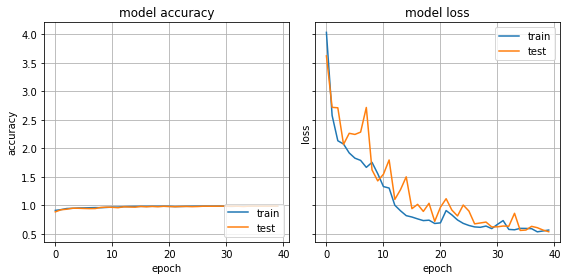

In [9]:
plot_learningcurves(results.history['loss'], results.history['val_loss'], results.history['acc'], results.history['val_acc'])

--2019-10-01 10:39:59--  https://i.pinimg.com/originals/de/b9/90/deb9907931b0800ff942c1254ffc2f8e.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.36.76.189, 2600:1419:3c00:181::1931, 2600:1419:3c00:180::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.36.76.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745849 (728K) [image/jpeg]
Saving to: ‘corr.jpeg’

corr.jpeg           100%[===================>] 728,37K  3,11MB/s    in 0,2s    

2019-10-01 10:39:59 (3,11 MB/s) - ‘corr.jpeg’ saved [745849/745849]



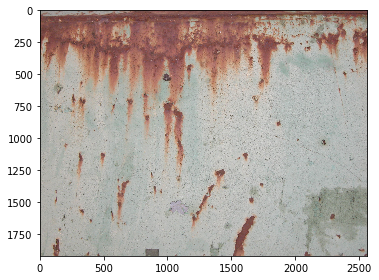

1/1 [==============================] - 0s 4ms/sample


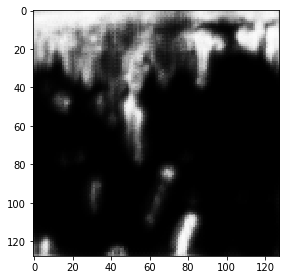

In [10]:
#teste final em imagem do Google
!wget --output-document=corr.jpeg https://i.pinimg.com/originals/de/b9/90/deb9907931b0800ff942c1254ffc2f8e.jpg
    
im = imread("corr.jpeg")

imshow(im)
plt.show()

im = resize(im, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

im = im[np.newaxis, ...] #Modelo espera 4d

predict = model.predict(im, verbose=1)
 
#predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()


--2019-10-01 10:40:02--  https://d11onib03523a2.cloudfront.net/media/articles/pop/corrosion-03.jpg
Resolving d11onib03523a2.cloudfront.net (d11onib03523a2.cloudfront.net)... 13.226.52.32, 13.226.52.183, 13.226.52.216, ...
Connecting to d11onib03523a2.cloudfront.net (d11onib03523a2.cloudfront.net)|13.226.52.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37177 (36K) [image/jpeg]
Saving to: ‘corr.jpeg’

corr.jpeg           100%[===================>]  36,31K  --.-KB/s    in 0,08s   

2019-10-01 10:40:03 (454 KB/s) - ‘corr.jpeg’ saved [37177/37177]



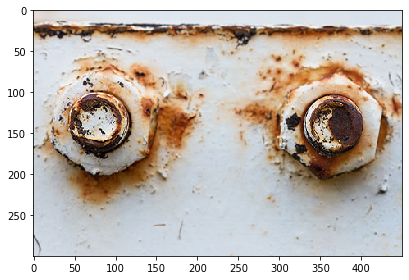

1/1 [==============================] - 0s 3ms/sample


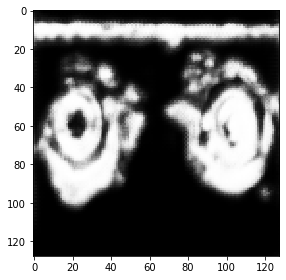

In [11]:
#teste final em imagem do Google
!wget --output-document=corr.jpeg https://d11onib03523a2.cloudfront.net/media/articles/pop/corrosion-03.jpg
    
im = imread("corr.jpeg")

imshow(im)
plt.show()

im = resize(im, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

im = im[np.newaxis, ...] #Modelo espera 4d

predict = model.predict(im, verbose=1)
 
#predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()


--2019-10-01 10:40:04--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSvCEpj9YstAqSLhJkJn95kGz6vtFhrAgig6V_0LBhc-J5LQNGu
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 216.58.202.206, 2800:3f0:4004:804::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|216.58.202.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6754 (6,6K) [image/jpeg]
Saving to: ‘corr.jpeg’

corr.jpeg           100%[===================>]   6,60K  --.-KB/s    in 0s      

2019-10-01 10:40:04 (24,5 MB/s) - ‘corr.jpeg’ saved [6754/6754]



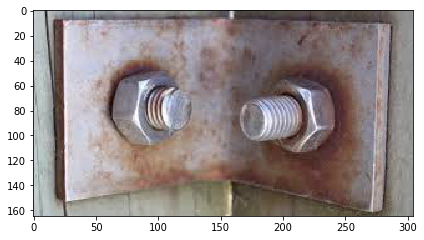

1/1 [==============================] - 0s 5ms/sample


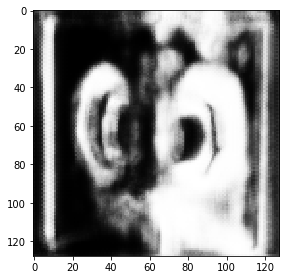

In [12]:
#teste final em imagem do Google
!wget --output-document=corr.jpeg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSvCEpj9YstAqSLhJkJn95kGz6vtFhrAgig6V_0LBhc-J5LQNGu"
    
im = imread("corr.jpeg")

imshow(im)
plt.show()

im = resize(im, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

im = im[np.newaxis, ...] #Modelo espera 4d

predict = model.predict(im, verbose=1)
 
#predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()


In [15]:
model.save("final_model.h5")

RuntimeError: Unable to create link (name already exists)